In [193]:
import numpy as np
import healpy as hp
from healpy.newvisufunc import projview

from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

import matplotlib
from matplotlib import pyplot as plt

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import maps
import utils
import selection_function_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [4]:
cmap_map = 'plasma'

## Parameters

In [8]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

In [9]:
name_catalog = '\emph{{Gaia}}-\emph{{unWISE}} Quasar Catalog'
abbrv_catalog = 'Quaia'

In [10]:
G_hi = 20.5
G_lo = 20.0

In [11]:
fn_gcatlo = f'../data/quaia_G20.0.fits'
fn_gcathi = f'../data/quaia_G20.5.fits'

fn_sello = f"../data/maps/selection_function_NSIDE64_G20.0.fits"
fn_selhi = f"../data/maps/selection_function_NSIDE64_G20.5.fits"

In [179]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
fn_starmap = f'../data/maps/map_stars_NSIDE{NSIDE}.npy'
fn_m10map = f'../data/maps/map_m10_NSIDE{NSIDE}.npy'
fn_mcsmap = f'../data/maps/map_mcs_NSIDE{NSIDE}.npy'

In [188]:
map_dust = np.load(fn_dustmap)
map_stars = np.load(fn_starmap)
map_m10 = np.load(fn_m10map)
map_mcs = np.load(fn_mcsmap)

## Load and plot data

In [14]:
tab_gcatlo = Table.read(fn_gcatlo)
N_gcatlo = len(tab_gcatlo)
print(f"Number of data sources: {N_gcatlo}")

Number of data sources: 755850


In [15]:
pixel_indices_gcatlo = hp.ang2pix(NSIDE, tab_gcatlo['ra'], tab_gcatlo['dec'], lonlat=True)
map_gcatlo = np.bincount(pixel_indices_gcatlo, minlength=NPIX)

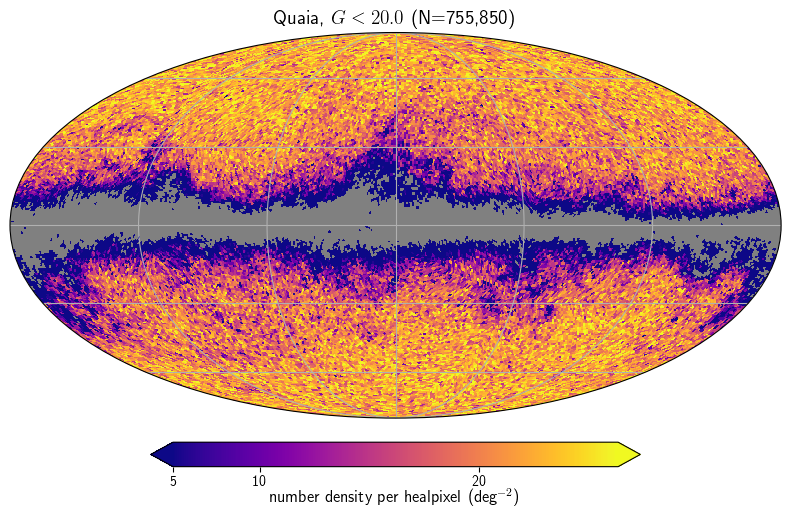

In [203]:
title_gcatlo = rf"Quaia, $G<{G_lo}$ (N={len(tab_gcatlo):,})"
projview(map_gcatlo, title=title_gcatlo,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=np.median(map_gcatlo)-np.std(map_gcatlo), max=np.median(map_gcatlo)+1.5*np.std(map_gcatlo), 
            norm='log', graticule=True,
            cbar_ticks=[5, 10, 20]) 

In [12]:
map_sello = hp.read_map(fn_sello)

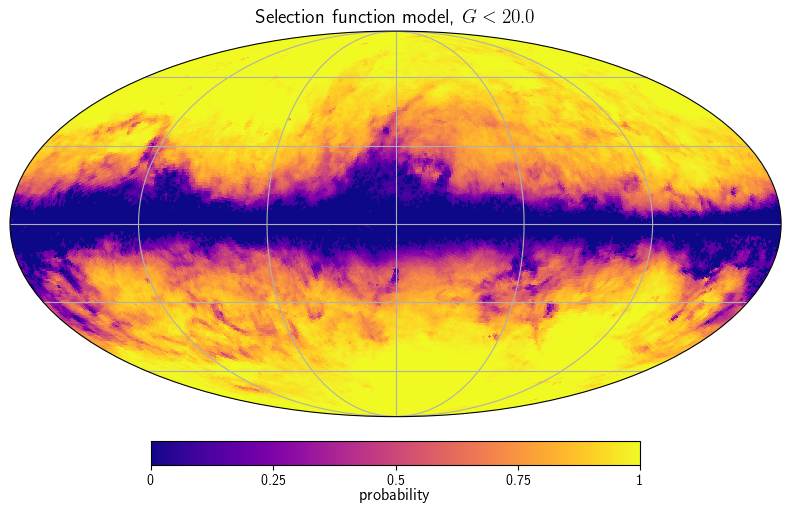

In [13]:
projview(map_sello, title=rf"Selection function model, $G<{G_lo}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True,
            cbar_ticks=[0,0.25,0.5,0.75,1.0]
            ) 

In [53]:
map_corrected = map_gcatlo / map_sello

/state/partition1/job-36235187/ipykernel_1404344/571298810.py:1: RuntimeWarning: invalid value encountered in divide
  map_corrected = map_gcatlo / map_sello


In [54]:
map_corrected_unseen = map_corrected.copy()
map_corrected_unseen[np.isnan(map_corrected)] = hp.UNSEEN

In [55]:
print(np.min(map_corrected_unseen))
print(np.min(map_corrected_unseen[~np.isnan(map_corrected)]))

-1.6375e+30
2.5229683752424883


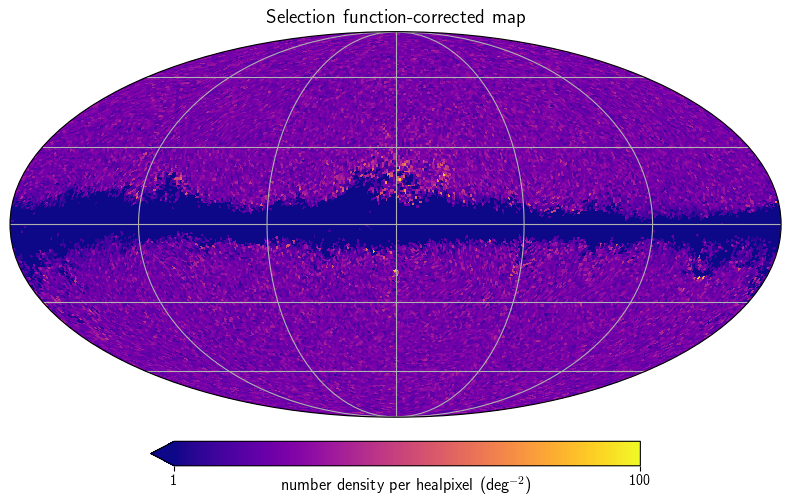

In [56]:
projview(map_corrected_unseen, title=rf"Selection function-corrected map",
unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
         min=1, max=100,
            #min=np.median(map_corrected)-np.std(map_corrected), max=np.median(map_corrected)+1.5*np.std(map_corrected), 
            #norm='log', 
             graticule=True,
            #cbar_ticks=[5, 10, 20]
        ) 

### Mask

In [198]:
i_include = (np.abs(map_b) > 20) & (map_dust < 0.5) & (map_sello > 0.5) & (map_mcs==0)
print(np.sum(i_include), len(i_include))

29916 49152


In [199]:
i_notnan = ~np.isnan(map_corrected)
i_include = i_include & i_notnan
print(np.sum(i_include))

29916


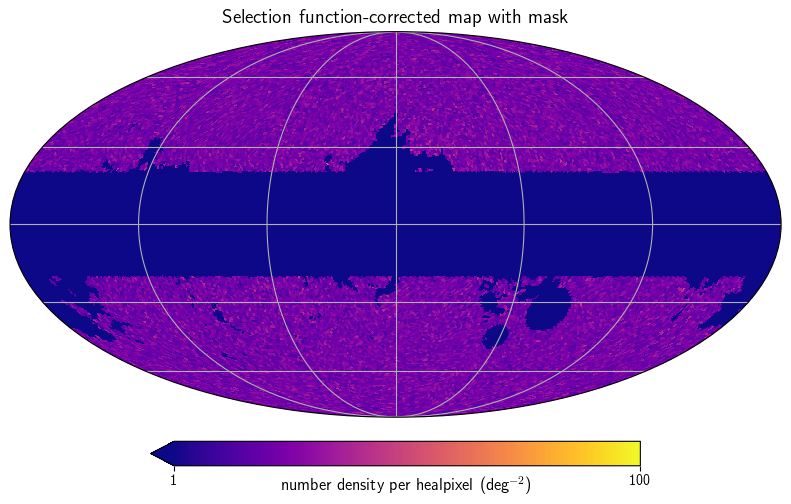

In [201]:
map_corrected_masked = map_corrected_unseen.copy()
map_corrected_masked[~i_include] = hp.UNSEEN

projview(map_corrected_masked, title=rf"Selection function-corrected map with mask",
unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
         min=1, max=100,
            #min=np.median(map_corrected)-np.std(map_corrected), max=np.median(map_corrected)+1.5*np.std(map_corrected), 
            #norm='log', 
             graticule=True,
            #cbar_ticks=[5, 10, 20]
        ) 

### Abssinb dependence

In [71]:
map_ra, map_dec = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat=True)

In [88]:
c_radec = SkyCoord(ra=map_ra*u.deg, dec=map_dec*u.deg, frame='icrs')
c_gal = c_radec.transform_to('galactic')
map_b = c_gal.b.value
map_abssinb = np.abs(np.sin(c_gal.b.to(u.rad).value))

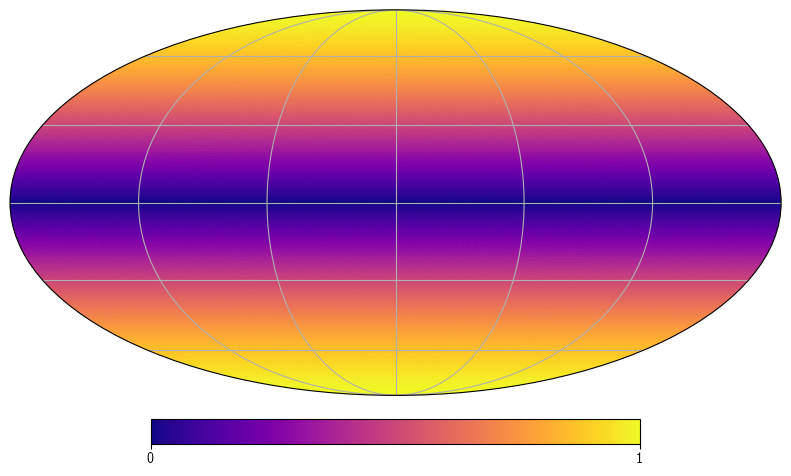

In [115]:
projview(map_abssinb,
            cmap=cmap_map, coord=['C', 'G'], 
            graticule=True,
            min=0, max=1
            ) 

### Correlations bw feature maps and counts (corrected and uncorrected)

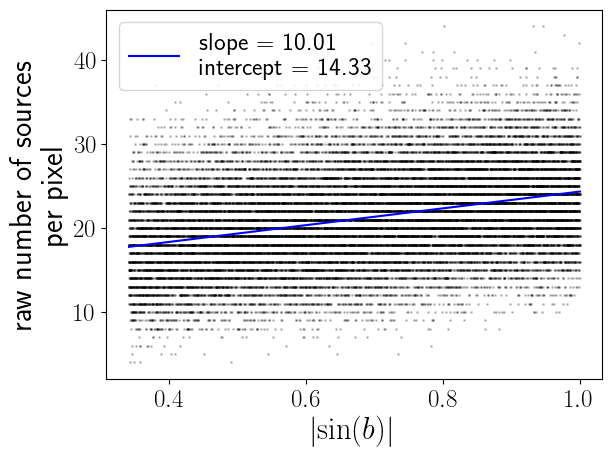

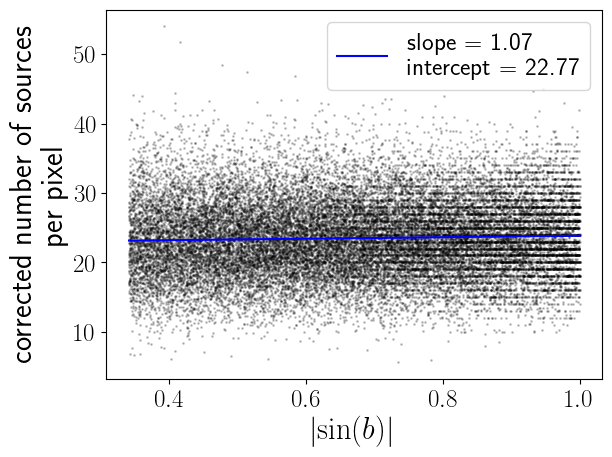

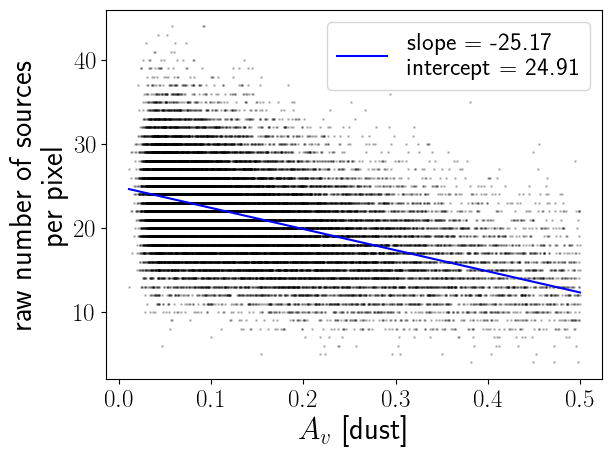

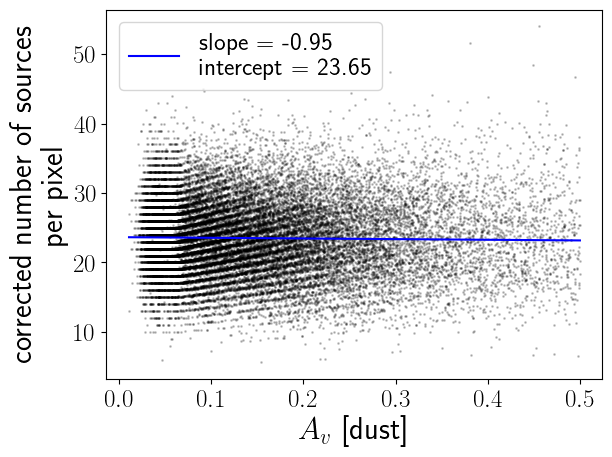

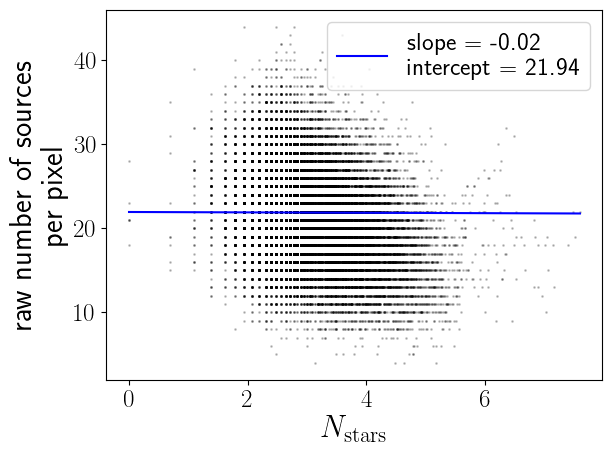

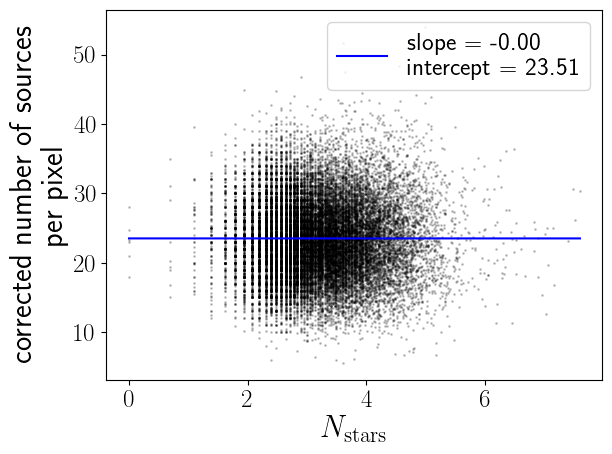

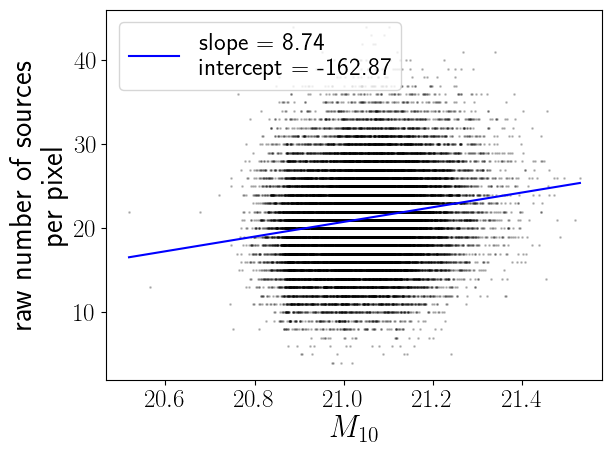

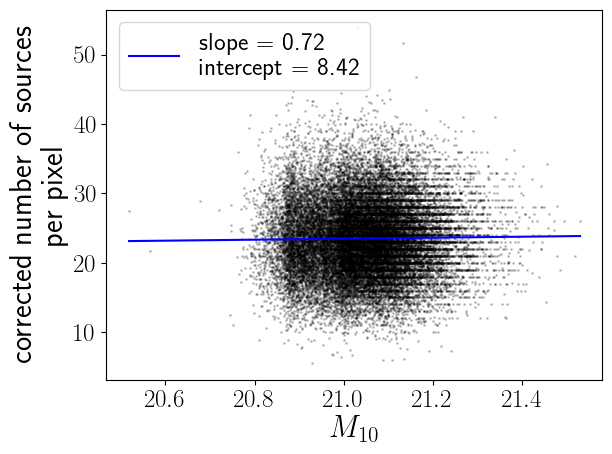

In [196]:
maps = {r'$|\mathrm{sin}(b)|$': map_abssinb,
        r'$A_v$ [dust]': map_dust,
        r'$N_\mathrm{stars}$': map_stars,
        r'$M_{10}$': map_m10,
        }

def fn_identity(x):
    return x

funcs = {r'$|\mathrm{sin}(b)|$': fn_identity,
        r'$A_v$ [dust]': selection_function_map.f_dust,
        r'$N_\mathrm{stars}$': selection_function_map.f_stars,
        r'$M_{10}$': selection_function_map.f_m10,
        }

for map_name, map_i in maps.items():

    func = funcs[map_name]
    
    A = np.vstack((np.ones(len(map_i[i_include])), map_i[i_include])).T
    
    # uncorrected 
    x, _, _, _ = np.linalg.lstsq(A, map_gcatlo[i_include], rcond=None)

    plt.figure()
    plt.scatter(func(map_i[i_include]), map_gcatlo[i_include], color='k', s=1, alpha=0.2)
    xx = np.linspace(np.min(func(map_i[i_include])), np.max(func(map_i[i_include])))
    yy = x[0] + x[1]*xx
    plt.plot(xx, yy, color='blue', label=f"slope = {x[1]:.2f} \n intercept = {x[0]:.2f}")

    plt.xlabel(map_name)
    plt.ylabel('raw number of sources\nper pixel')
    plt.legend()
    
    # sel-func-corrected 
    x, _, _, _ = np.linalg.lstsq(A, map_corrected[i_include], rcond=None)

    plt.figure()
    plt.scatter(func(map_i[i_include]), map_corrected[i_include], color='k', s=1, alpha=0.2)
    yy = x[0] + x[1]*xx
    plt.plot(xx, yy, color='blue', label=f"slope = {x[1]:.2f} \n intercept = {x[0]:.2f}")

    plt.xlabel(map_name)
    plt.ylabel('corrected number of sources\nper pixel')
    plt.legend()

### Looking into dust

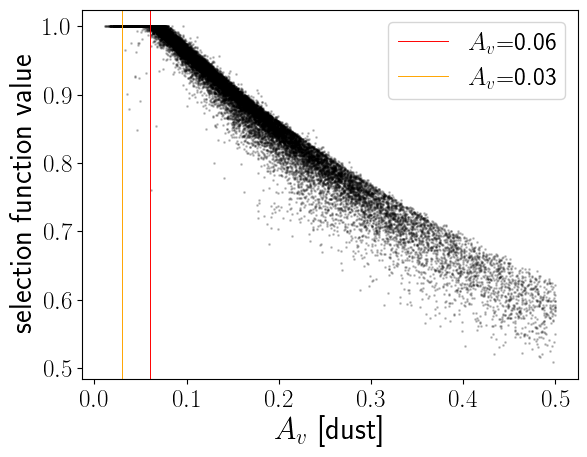

In [212]:
plt.scatter(selection_function_map.f_dust(map_dust[i_include]), map_sello[i_include], color='k', s=1, alpha=0.2)
plt.axvline(0.06, color='red', lw=0.7, label=r'$A_v$=0.06')
plt.axvline(0.03, color='orange', lw=0.7, label=r'$A_v$=0.03')

plt.xlabel(r'$A_v$ [dust]')
plt.ylabel('selection function value')
plt.legend()

In [215]:
print(np.sum(map_dust[i_include]<0.06))
print(np.sum(map_dust[i_include]<0.03))

5999
513


In [217]:
np.sum(map_sello==1)

7042